In [ ]:
%matplotlib inline

In [20]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import scipy.stats
import statsmodels.api as sm

In [3]:
#simple function to calculate basepair composition of sequence
def bp_calc(seq):
    seqlen=len(seq)
    bpcomp=np.divide(1.0*np.array([seq.count('A'),seq.count('C'),seq.count('G'),seq.count('T')]),seqlen)
    return bpcomp

In [4]:
outputpath='/Users/atray/Desktop/RESEARCH_DATA/CHIMERA/plots/dropseq/'
#minimum TPT threshold
TPT_threshold=0.05

In [5]:
#Read Dropseq outputs containing molecule information
Th=pd.read_csv('PATH2HUMAN_molBC'+'/SpeciesMix_HundredSTAMP_bq10_star_HUMAN_auto_molBC.txt.gz',sep='\t')
Tm=pd.read_csv('PATH2HUMAN_molBC'+'SpeciesMix_HundredSTAMP_bq10_star_MOUSE_auto_molBC.txt.gz',sep='\t')

In [6]:
Th['human']=[1.0]*len(Th)
Th['mouse']=[0.0]*len(Th)
Tm['human']=[0.0]*len(Tm)
Tm['mouse']=[1.0]*len(Tm)

In [7]:
Th.head()

,Cell Barcode,Gene,Molecular_Barcode,Num_Obs,human,mouse
0,CTAAGTAGCTTT,A1BG,CGGTCGTC,4,1.0,0.0
1,GAAGTTGGCGGA,A1BG,TCCTTTGA,3,1.0,0.0
2,GACACTTCATCG,A1BG,ATTGGCAT,2,1.0,0.0
3,GTTATCCACCTT,A1BG,CGGTCTGG,3,1.0,0.0
4,GTTATCCACCTT,A1BG,CCTGTGGG,4,1.0,0.0


In [8]:
T=pd.concat([Th,Tm])

In [9]:
T['bcumi']=[x+'-'+y for x,y in zip(T['Cell Barcode'],T['Molecular_Barcode'])]

In [10]:
BCUMI_group=T.groupby('bcumi').sum()
BCUMI_group['gpt']=BCUMI_group['human']+BCUMI_group['mouse']

In [11]:
BCUMI_group=pd.DataFrame(BCUMI_group[['Num_Obs','gpt']])
BCUMI_group.columns=['total_reads','gpt']
T_tot=T.copy()
T_tot.index=T_tot['bcumi']
T_tot=T_tot.join(BCUMI_group)
T_tot['TPT']=1.0*(np.divide(1.0*T_tot['Num_Obs'],T_tot['total_reads']))

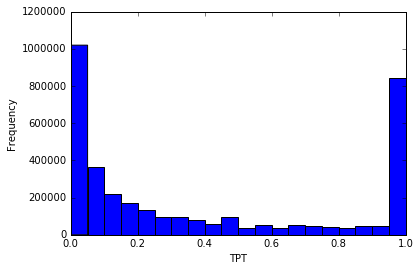

In [12]:
plt.hist(T_tot['TPT'],20)
plt.xlabel('TPT')
plt.ylabel('Frequency')

The following code computes the expected number of genes expected per unique cell barcode UMI pair based on the basepair composition diversity of the UMI

In [13]:
df_umi=pd.DataFrame([list(x) for x in T_tot['Molecular_Barcode']])
bp_umi=[bp_calc(''.join(np.array(df_umi[x]))) for x in range(np.shape(df_umi)[1])]

In [14]:
#use per base relative entropy to calculate the effective diversity of the umi library based on basepair composition bias
def s_entropy(p):
    y=[x*np.log2(x) for x in p]
    return(np.sum(y))

perbp_entropy=4.0*np.divide([s_entropy(x) for x in bp_umi],s_entropy([0.25,0.25,0.25,0.25]))

In [15]:
total_complexity=np.power(4,8)
effective_complexity=np.product(perbp_entropy)
print('total complexity would be '+str(total_complexity)+' actual complexity is '+str(effective_complexity))

total complexity would be 65536 actual complexity is 30439.0625303


In [18]:
T_tot['unique']=[1.0]*len(T_tot)
Tbc=T_tot.groupby('Cell Barcode').sum()
df_pmf=pd.DataFrame([scipy.stats.poisson.pmf(np.linspace(1,100,100),np.divide(1.0*x,effective_complexity)) for x in Tbc['unique']])
df_pmf=df_pmf.divide(df_pmf.sum(axis=1),axis=0)
df_cdfs=df_pmf.cumsum(axis=1)
mean_cdf=df_cdfs.mean()
std_cdf=df_cdfs.std()

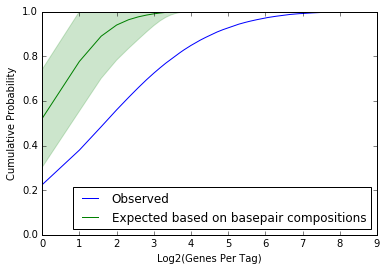

In [21]:
ysort=np.sort(np.log2(T_tot['gpt']))
y=np.cumsum(ysort)
y=np.divide(1.0*y,np.max(y))
ecdf = sm.distributions.ECDF(ysort)
x = np.log2(np.array(range(np.power(2,9)))+1)#np.linspace(min(ysort), max(ysort),10000)
y = ecdf(x)
plt.plot(x, y,label='Observed')
plt.plot(np.log2(np.linspace(1,100,100)),mean_cdf,label='Expected based on basepair compositions')
plt.fill_between(np.log2(np.linspace(1,100,100)),mean_cdf-std_cdf,mean_cdf+std_cdf,color='green',alpha=0.2)
plt.ylim([0,1])
plt.legend(loc=4)
plt.xlabel('Log2(Genes Per Tag)')
plt.ylabel('Cumulative Probability')

Now we filter on TPT and return a new expression matrix

In [22]:
filter_logical=T_tot['TPT']<TPT_threshold
T_F=T_tot[filter_logical][['Cell Barcode','Gene','unique']]
T_F.index=[(x,y) for x,y in zip(T_F['Cell Barcode'],T_F['Gene'])]
T_F=T_F.groupby(T_F.index).sum()
print('Filtered '+str(np.round(100*np.mean(filter_logical),2))+'% of molecules')

Filtered 28.27% of molecules


In [23]:
T_F.head()

,unique
"(AACCTATGGGCC, 2700060E02Rik)",1.0
"(AACCTATGGGCC, AAED1)",2.0
"(AACCTATGGGCC, AAGAB)",1.0
"(AACCTATGGGCC, AAMP)",4.0
"(AACCTATGGGCC, AATF)",1.0


In [24]:
def str2index(strlist):
    reduced=pd.DataFrame(list(set(np.sort(strlist))))
    reduced=reduced.reset_index()
    reduced.index=reduced[0]
    dftmp=pd.DataFrame(strlist,index=strlist)
    dftmp=dftmp.merge(reduced,how='left')['index']
    return np.array(dftmp),list(reduced[0])

In [25]:
tfrow=[x[1] for x in T_F.index]
tfrow,gnames=str2index(tfrow)
tfcol=[x[0] for x in T_F.index]
tfcol,cnames=str2index(tfcol)
tfdata=np.array(T_F['unique'])
tmpcol=pd.DataFrame(np.unique(tfcol))
tmpcol['unind']=range(len(tmpcol))

In [26]:
dftfcol=pd.DataFrame(tfcol)
dftfcol=dftfcol.merge(tmpcol,on=0)
tfcol=np.array(dftfcol['unind'])
EXPR_MAT=scipy.sparse.csr_matrix((tfdata,(tfrow,tfcol)),shape=(np.max(tfrow)+1,np.max(tfcol)+1)).toarray()
EXPR_MAT=pd.DataFrame(EXPR_MAT)
EXPR_MAT.index=gnames
EXPR_MAT.columns=cnames

In [27]:
#WARNING this matrix contains both human and mouse genes, but you can filter as needed
EXPR_MAT.head()

,ATCTTCGGATCA,TACAATTAAGGC,TCGACCTGTACT,TCTGGATGCGCA,GGATACATGGTA,CACTCTGCAAGG,GAAGTTGGCGGA,AGACTTCCCTCG,AAGTAAGCAAGC,TGGCTATACCAA,...,GAGACTGCCCCA,GAATGGCATGCT,CCTAGACGTAGT,TTGCCTTACGCG,GACACTTCATCG,CGTGATGACCCT,AACCTATGGGCC,CCTTGTACTTTT,TGAATGTTTGAC,TCTCACAATGGG
Plekhg2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Plekhg4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nsa2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
Nampt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
Man2a1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
EXPR_MAT.to_csv(outputpath+'/expr_mat_TPTfiltered.txt',sep='\t')